# Simple Vectorfield Model

*mZargham*

Demonstration of hyperbolic coordinates and vectorfield interpretation of constant product market maker activity

In [1]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 100


In [3]:
x0 = 20
y0 = 100

#cartersian to hyperbolic
def xy2uv(x,y):

    u = np.log(np.sqrt(x/y))
    v = np.sqrt(x*y)

    return (u,v)

#hyperbolic to cartesian
def uv2xy(u,v):

    x = v*np.exp(u)
    y = v*np.exp(-u)

    return (x,y)

u0, v0 = xy2uv(x0,y0)

genesis_states = {
    'cartesian': (x0,y0),
    'hyperbolic': (u0,v0)
}

This snippet is intended to demonstrate the impact of latent market forces on an AMM using a simple vectorfield representation.

For simplicity we will construct a simple vector field around an equilibrium characterized by $P(x,y) = \frac{x}{y} = P^*$.

While our market is characterized by Quadrant I of the Cartesian plane, we are working with the idealized constant product market maker so there is an invariant function $V(x,y) = x \cdot y = V^*$

The resulting dynamical system can be expressed succinctly in hyperbolic coordinates

$u = \ln \sqrt{\frac{x}{y}} = \ln \sqrt{P(x,y)}$

$v = \sqrt{x\cdot y} = \sqrt{V(x,y)}$

By excluding the add/remove liquidity mechanism we can characterize the vectorfield using only the $u$ dimension as fixed at $v = v_0 = \sqrt{V^*}$

$\ddot{u} = -k(u-u^*)$

$\ddot{v} = \dot{v} = 0$ 

where $u^* = \ln \sqrt{P^*}$ and $k$ is gain coeficient.

we can construct a vectorfield representation of this in cartesian coordinates as follows



In [4]:
# vectorfield
k=.5
pstar = 1
ustar = np.log(np.sqrt(pstar))

x,y = np.meshgrid(np.linspace(1,2001,21),np.linspace(1,2001,21))

u, v = xy2uv(x,y)

du = -k*(u-ustar)
dv = np.zeros_like(v)

xplus, yplus = uv2xy(u+du,v+dv)
dx = (xplus-x)
dy = (yplus-y)



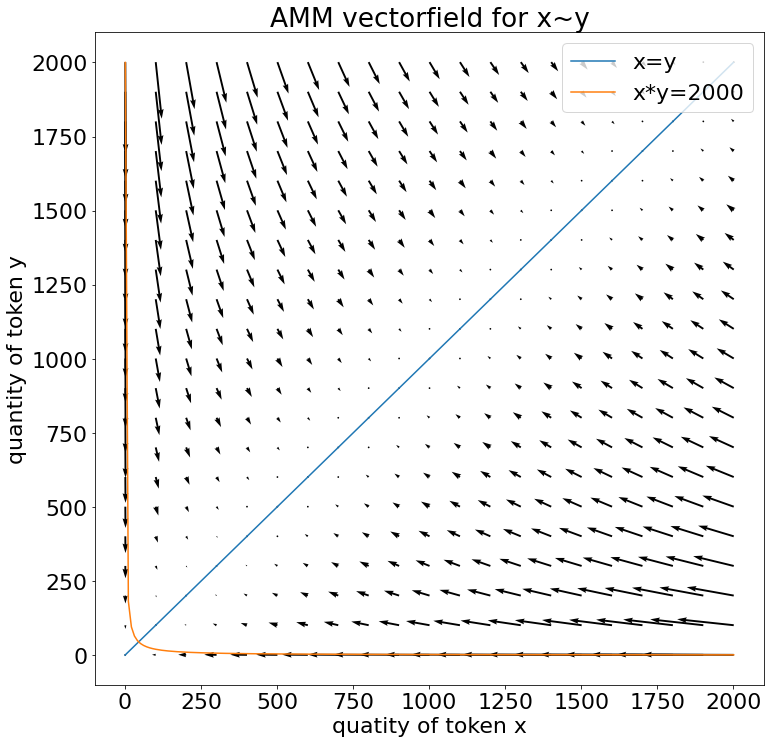

In [5]:
plt.rcParams.update({'font.size': 22})

plt.xlabel('quatity of token x')
plt.ylabel('quantity of token y')
plt.plot([0,2000], [0,2000], np.linspace(1,2001, 201), 2000/np.linspace(1,2001, 201))
plt.legend(["x=y", "x*y=2000"])
plt.quiver(x,y,dx,dy)
plt.title('AMM vectorfield for x~y')


f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(12)

In [6]:

def applyField(params, 
                substep, 
                state_history, 
                prev_state):
    pstar = params['pstar']
    ustar = np.log(np.sqrt(pstar))
    
    u, __ = prev_state['hyperbolic']
    error = u-ustar

    du = -params['field']*error + params['noise']*np.random.randn()

    return {'du':du}

In [7]:
def update_hyperbolic(params, 
                substep, 
                state_history, 
                prev_state, 
                policy_input):
    u, v = prev_state['hyperbolic']
    u = u+policy_input['du']
    point = (u, v)

    return ('hyperbolic', point)

def update_cartesian(params, 
                substep, 
                state_history, 
                prev_state, 
                policy_input):
    u, v = prev_state['hyperbolic']
    u = u+policy_input['du']

    x,y = uv2xy(u,v)
    point = (x, y)

    return ('cartesian', point)

In [8]:

sys_params = {
    'pstar': [1],
    'field': [.25],
    'noise' : [.05]
}


In [9]:

partial_state_update_blocks = [
    {
        'policies': {applyField
            
        },
        'variables': {
            'cartesian': update_cartesian,
            'hyperbolic': update_hyperbolic
        }
    }
]

sim_config = {
    'N': MONTE_CARLO_RUNS,
    'T': range(SIMULATION_TIMESTEPS),
    'M': sys_params
}

In [10]:
sim_params = config_sim(sim_config)
print(sim_params)


[{'N': 1, 'T': range(0, 100), 'M': {'pstar': 1, 'field': 0.25, 'noise': 0.05}}]


In [11]:

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=genesis_states,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

In [12]:

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.27
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 3, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 3, 1, 2)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.01s


In [13]:
df = pd.DataFrame(raw_system_events)
df.head()

,cartesian,hyperbolic,simulation,subset,run,substep,timestep
0,"(20, 100)","(-0.8047189562170503, 44.721359549995796)",0,0,1,0,0
1,"(24.023511981477466, 83.25177440925516)","(-0.6214182130876543, 44.721359549995796)",0,0,1,1,1
2,"(28.11915651883285, 71.12588881037371)","(-0.4640001590525401, 44.721359549995796)",0,0,1,1,2
3,"(29.456701826724018, 67.8962638711147)","(-0.4175297792902597, 44.721359549995796)",0,0,1,1,3
4,"(32.0249160927685, 62.45137361816905)","(-0.33393700204574284, 44.721359549995796)",0,0,1,1,4


In [14]:
df['x'] = df.cartesian.apply(lambda z: z[0])
df['y'] = df.cartesian.apply(lambda z: z[1])
df['dx']= df.x.diff()
df['dy']= df.y.diff()

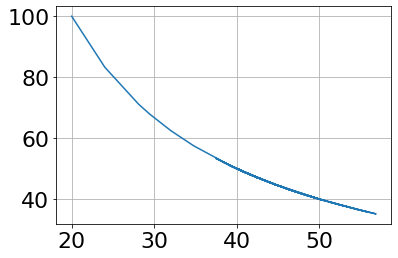

In [15]:
plt.plot(df.x,df.y)
plt.grid('square')

(array([17., 32., 38.,  8.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.61841449, 0.83749377, 1.05657304, 1.27565232, 1.49473159,
        1.71381087, 1.93289014, 2.15196942, 2.3710487 , 2.59012797,
        2.80920725, 3.02828652, 3.2473658 , 3.46644507, 3.68552435,
        3.90460362, 4.1236829 , 4.34276217, 4.56184145, 4.78092072,
        5.        ]),
 <BarContainer object of 20 artists>)

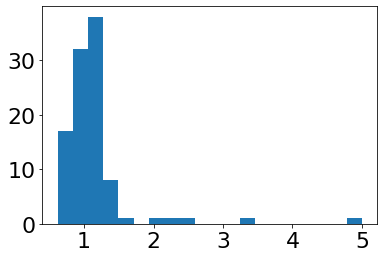

In [16]:
plt.hist(df.y/df.x, bins=20)

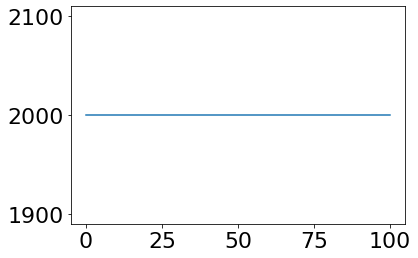

In [17]:
plt.plot(df.index,df.x*df.y)

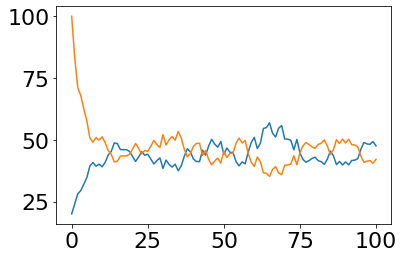

In [18]:
plt.plot(df.index,df.x, df.index, df.y)

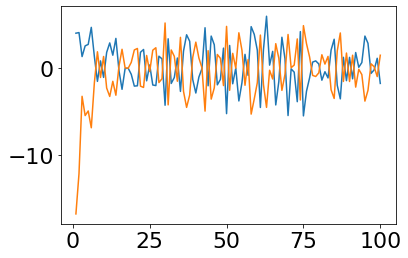

In [19]:
plt.plot(df.index,df.dx, df.index, df.dy)